In [1]:
import argparse
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from model import RobustModel
import numpy as np
import scipy.ndimage
from PIL import Image as PILImage

# dataset
import torchvision 
from torchvision import datasets
from torchvision import transforms
import splitfolders

import cv2

#model
from model import RobustModel
from CNN import ModelCNN

In [44]:
learning_rate = 0.0005
batch_size = 16
epoch_num = 100

In [45]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(1)])
train_data =  torchvision.datasets.ImageFolder('./resources/reduce_data/train', transform=trans)
val_data =  torchvision.datasets.ImageFolder('./resources/reduce_data/val', transform=trans)

In [47]:
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
devLoader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [31]:
# gpu 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [48]:
def check_model(model):
    n_predict = 0
    n_correct = 0
    model.epochs = 2
    for data in devLoader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        n_predict += len(predicted)
        n_correct += (labels == predicted).sum()

    return n_correct/n_predict


In [36]:
def graph(data):
    plt.figure(figsize=(18,6))
    plt.plot(range(1000,len(data)*1000+1, 1000),data)

In [12]:
models = []
accuracies = []
losses = []

In [380]:
# print("model state dict")
# for param in models[-1].state_dict():
#     print(param, "\t", models[-1].state_dict()[param].size())


In [51]:
# train model
def train_model(model, criterion, optimizer, scheduler):
    model.train()
    accuracy_list = []
    running_loss_list = []
    running_loss = 0.0
    for epoch in range(epoch_num):
        for i, data in enumerate(trainLoader):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 1000 == 0 :
                # check accuracy by validation data
                accuracy_list.append(check_model(model))
                running_loss_list.append(running_loss/1000)
                print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss_list[-1]) )
                print(f"Accuracy:{accuracy_list[-1]:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished training")
    return model, accuracy_list, running_loss_list

In [413]:

model5 = ModelCNN(1)
model5.to(device) # gpu or CPU
criterion5 = nn.CrossEntropyLoss()
optimizer5 = optim.Adam(model5.parameters(), lr = learning_rate)
scheduler5 = optim.lr_scheduler.ExponentialLR(optimizer5, gamma=0.9)

model2, accuracy_list5, running_loss_list5 = train_model(model5, criterion=criterion5, optimizer=optimizer5, scheduler=scheduler5)
models.append(model5)
accuracies.append(accuracy_list5)
losses.append(running_loss_list5)



[1,   500] loss: 1.907
Accuracy:0.542
[1,  1000] loss: 1.078
Accuracy:0.699
[1,  1500] loss: 0.787
Accuracy:0.774
[1,  2000] loss: 0.603
Accuracy:0.828
[1,  2500] loss: 0.508
Accuracy:0.855
[1,  3000] loss: 0.439
Accuracy:0.873
[1,  3500] loss: 0.418
Accuracy:0.891
[1,  4000] loss: 0.389
Accuracy:0.899
[1,  4500] loss: 0.315
Accuracy:0.900
[1,  5000] loss: 0.317
Accuracy:0.917
[2,   500] loss: 0.275
Accuracy:0.914
[2,  1000] loss: 0.275
Accuracy:0.919
[2,  1500] loss: 0.274
Accuracy:0.927
[2,  2000] loss: 0.236
Accuracy:0.926
[2,  2500] loss: 0.232
Accuracy:0.931
[2,  3000] loss: 0.210
Accuracy:0.938
[2,  3500] loss: 0.233
Accuracy:0.934
[2,  4000] loss: 0.226
Accuracy:0.939
[2,  4500] loss: 0.195
Accuracy:0.947
[2,  5000] loss: 0.211
Accuracy:0.945
[3,   500] loss: 0.189
Accuracy:0.950
[3,  1000] loss: 0.176
Accuracy:0.950
[3,  1500] loss: 0.172
Accuracy:0.951
[3,  2000] loss: 0.171
Accuracy:0.954
[3,  2500] loss: 0.171
Accuracy:0.949
[3,  3000] loss: 0.187
Accuracy:0.951
[3,  3500] l

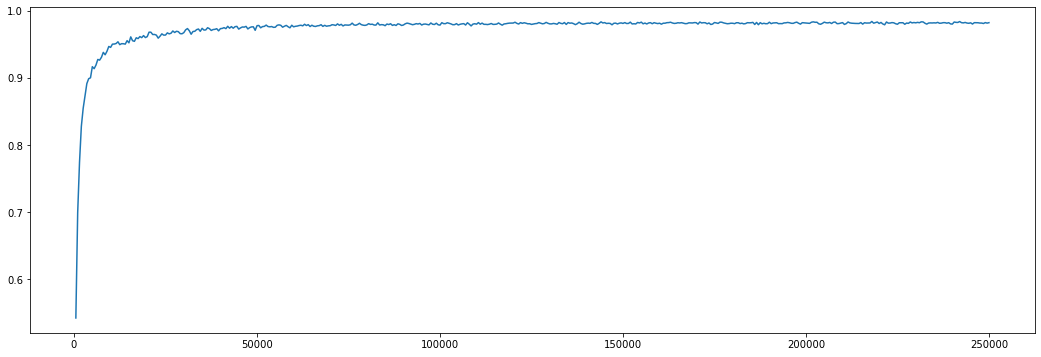

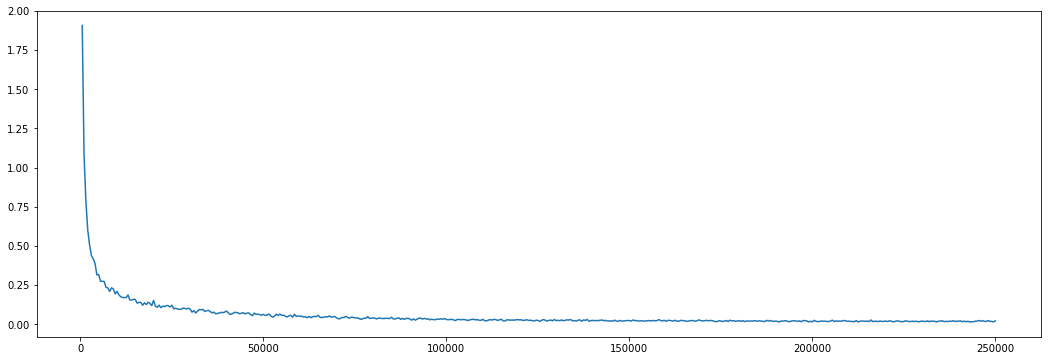

In [416]:
graph(accuracies[-1])
graph(losses[-1])

In [417]:
model_outputs = "./models/CNN4.pt"
torch.save(models[-1].state_dict(), model_outputs)